![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-ocr-workshop/blob/TrainingNotebooks/tutorials/Certification_Trainings/others/SparkOcrImageCleaner.ipynb)

## Blogposts and videos

- [Text Detection in Spark OCR](https://medium.com/spark-nlp/text-detection-in-spark-ocr-dcd8002bdc97)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Extract Tabular Data from PDF in Spark OCR](https://medium.com/spark-nlp/extract-tabular-data-from-pdf-in-spark-ocr-b02136bc0fcb)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)


**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

In [1]:
import json, os
import sys

if 'google.colab' in sys.modules:
    from google.colab import files

    if 'spark_ocr.json' not in os.listdir():
      license_keys = files.upload()
      os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

Saving spark-license-v410.json to spark-license-v410.json


In [2]:
!pip install transformers

# Installing pyspark and spark-nlp
%pip install --upgrade -q pyspark==3.2.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
#! pip uninstall spark-ocr -Y
%pip install spark-ocr==$OCR_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.0/616.0 KB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 KB 21.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.johnsnowlabs.com/4.1.0-52f8e0a3b8cf4b1b63c864d38b2851b1f5484f25
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [2]:
import pkg_resources

from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *
from sparkocr.metrics import score

In [3]:
# Start spark
spark = start(secret=SPARK_OCR_SECRET, nlp_version=PUBLIC_VERSION)

Spark version: 3.2.1
Spark NLP version: 4.1.0
Spark OCR version: 4.1.0



## Read Pdf as binary file and display it


    Image #0:
    Origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/pdfs/noised.pdf
    Resolution: 300 dpi
    Width: 2479 px
    Height: 3508 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


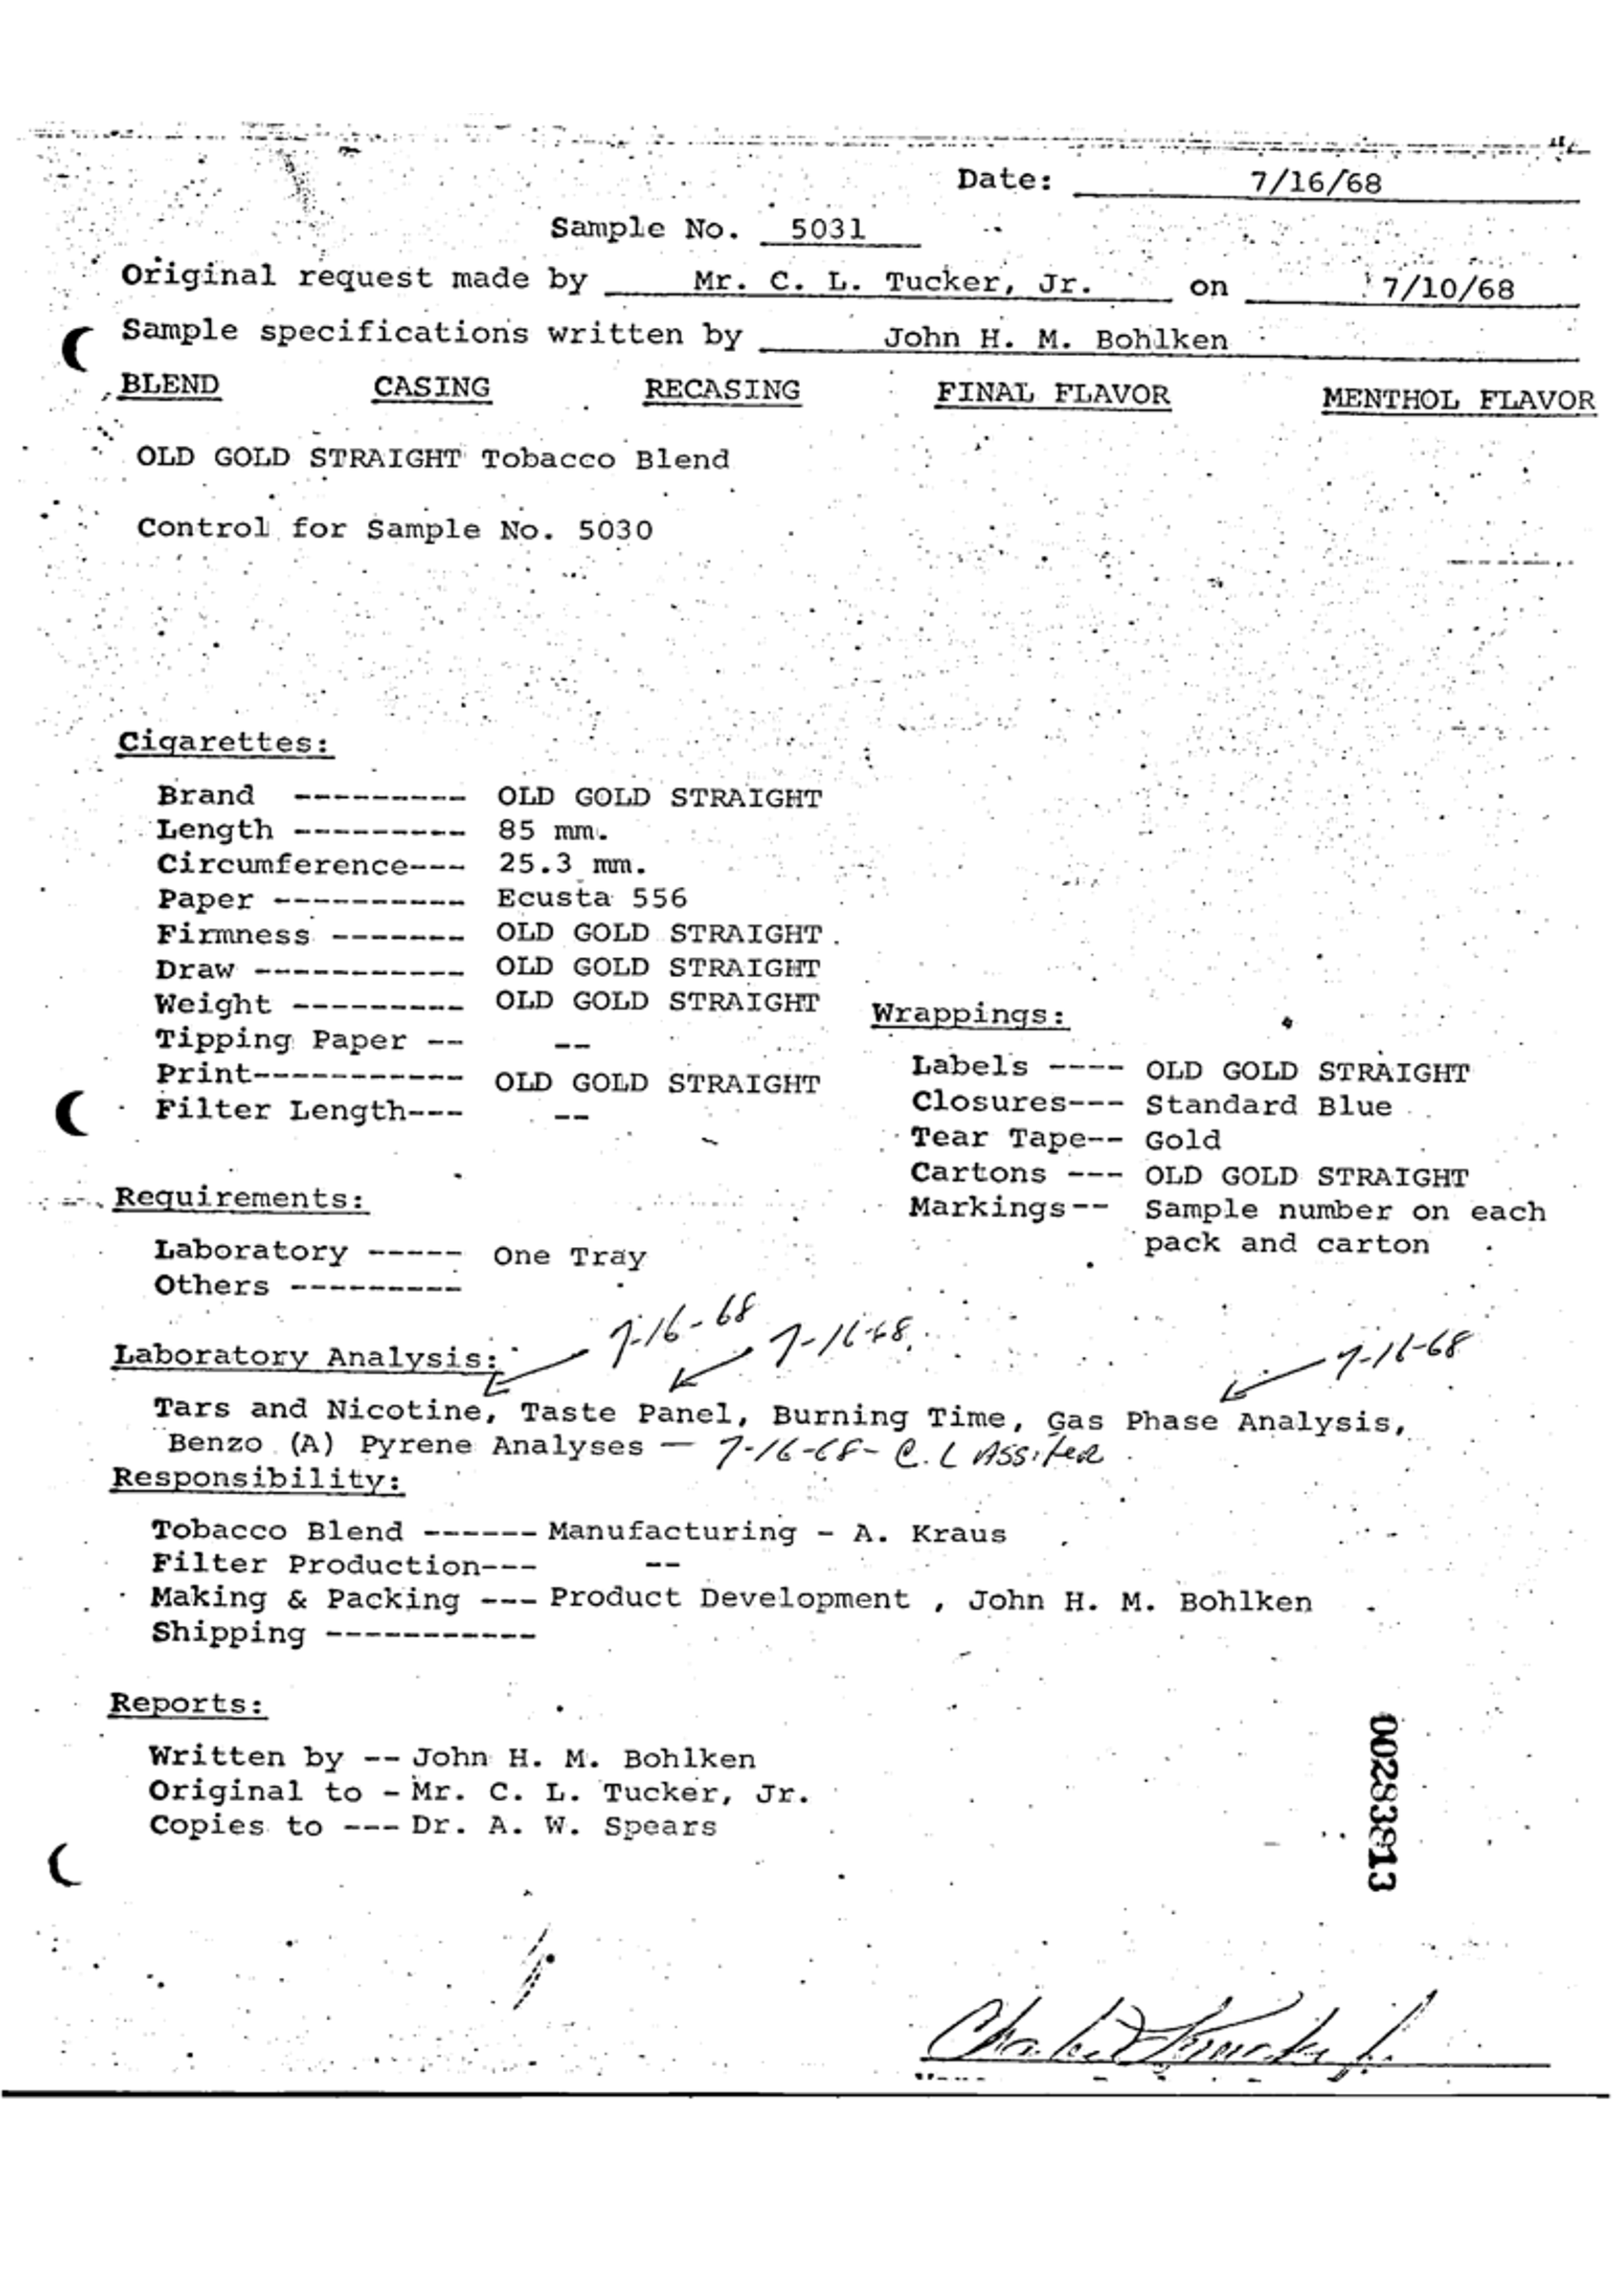

In [ ]:
pdf_example ='data/pdfs/noised.pdf'
pdf_example_df = spark.read.format("binaryFile").load(pdf_example).cache()

display_pdf(pdf_example_df)

## Define OCR transformers and pipeline

In [ ]:
pdf_to_image = PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setResolution(300)

ocr = ImageToText() \
    .setInputCol("image") \
    .setOutputCol("text") \
    .setConfidenceThreshold(70) \
    .setIgnoreResolution(False)

cleaner = ImageTextCleaner \
    .pretrained("text_cleaner_v1", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("corrected_image") \
    .setMedianBlur(0) \
    .setSizeThreshold(10) \
    .setTextThreshold(0.3) \
    .setLinkThreshold(0.2) \
    .setPadding(5) \
    .setBinarize(False)

ocr_corrected = ImageToText() \
    .setInputCol("corrected_image") \
    .setOutputCol("corrected_text") \
    .setConfidenceThreshold(70) \
    .setIgnoreResolution(False)

pipeline = PipelineModel(stages=[
    pdf_to_image,
    ocr,
    cleaner,
    ocr_corrected
])


text_cleaner_v1 download started this may take some time.
Approximate size to download 73.5 MB


## Display results without correction

In [ ]:
results = pipeline.transform(pdf_example_df).cache()

print(f"Detected text:\n{results.select('text').collect()[0].text}")

Detected text:
 

 

 

Sample specifications written by
 , BLEND CASING RECASING

- OLD GOLD STRAIGHT Tobacco Blend

Control for Sample No. 5030

Cigarettes:

OLD GOLD STRAIGHT

 

John H. M. Bohlken

FINAL FLAVOR MENTHOL FLAVOR

Tars and Nicotine, Taste Panel, Burning Time, Gas Phase Analysis,
Benzo (A) Pyrene Analyses — T/C -CF~ O.C S51: Fee -

Written by -- John H. M. Bohlken
Original to -Mr. C. L. Tucker, dr.
Copies to ---Dr. A. W. Spears

C

~




## Dispaly corrected image


    Image #0:
    Origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/pdfs/noised.pdf
    Resolution: 300 dpi
    Width: 2479 px
    Height: 3508 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


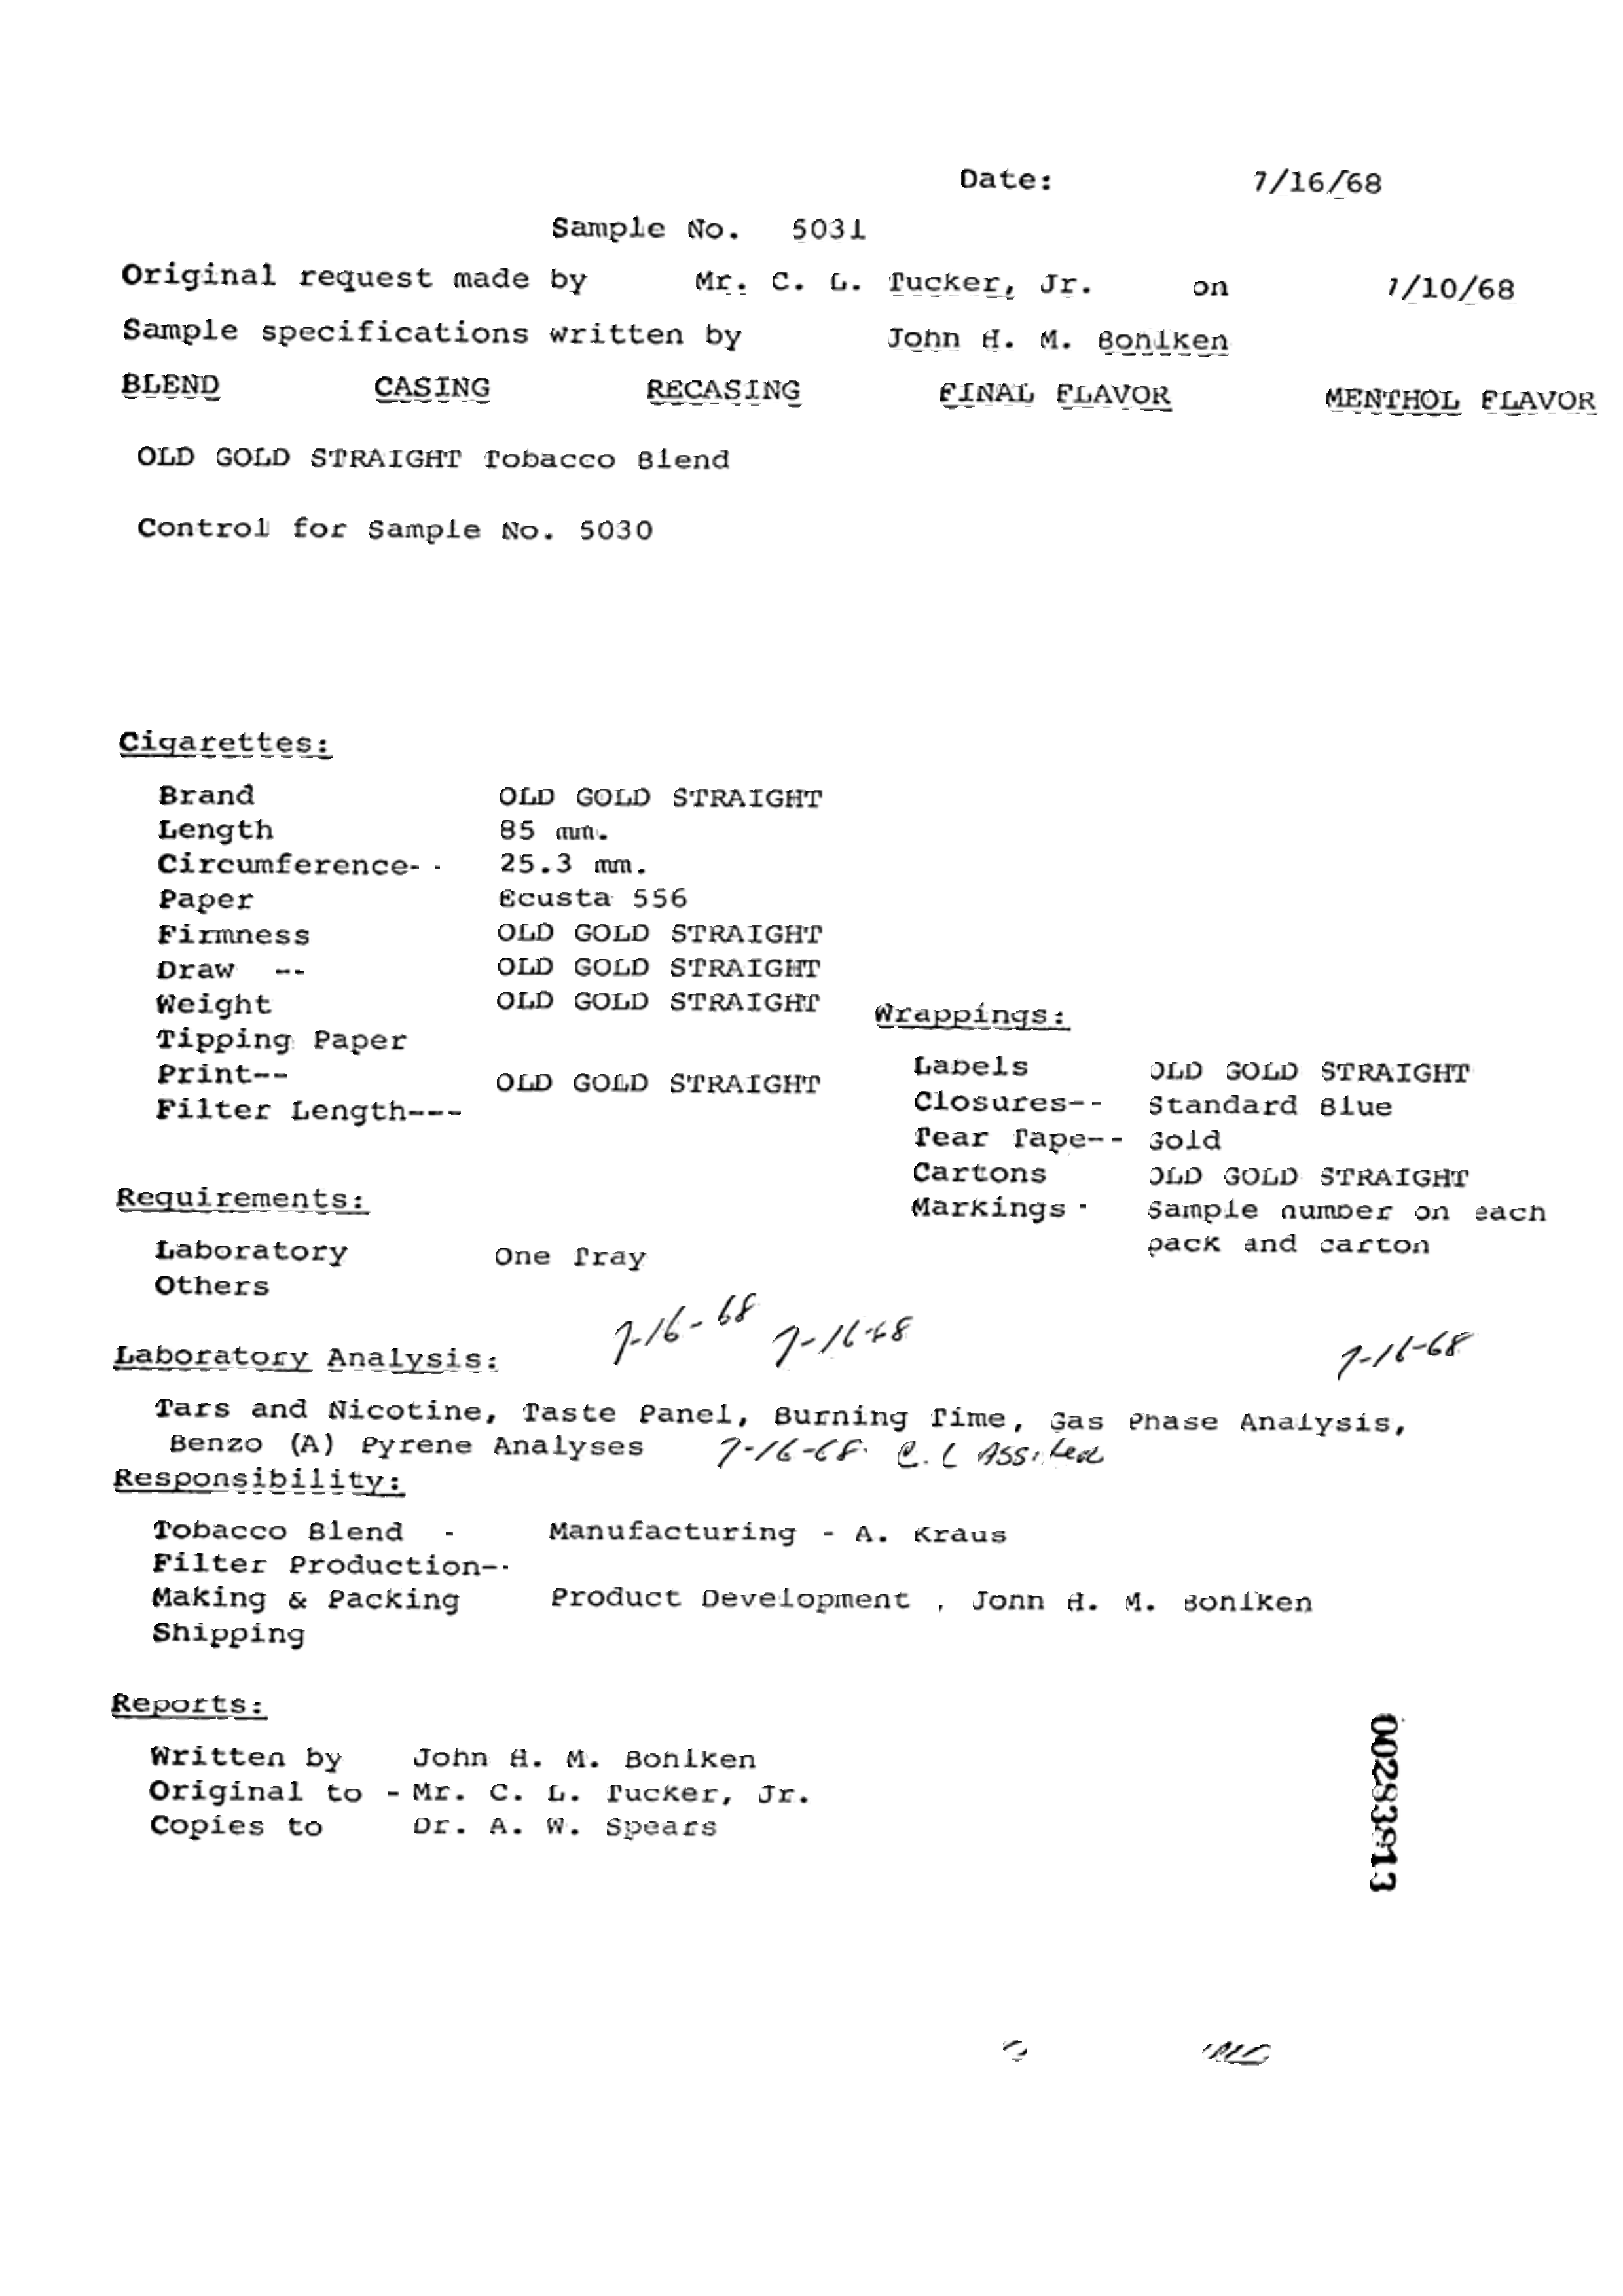

In [ ]:
display_images(results, "corrected_image")

## Display recognized text from the corrected image

In [ ]:
print(f"Detected text from corrected image:\n{results.select('corrected_text').collect()[0].corrected_text}")

Detected text from corrected image:
Date: 7/16/68
Sample Mo. 5031

Original request made by Mr. C. G. fucker, Jr. on 7/10/68
Sample specifications written by Jonn 4d. M. Bonlken
BLEND CASING RECASING FINAL FLAVOR MENTHOL FLAVOR

OLD GOLD STRAIGHT Tobacco Blend

Control for Sample No. 5030

Cigarettes:
Brand OLD GOLD STRAIGHT
Length 85 mn.
Circumference- - 25.3 mm.
Paper Ecusta 556
Fixrmness OLD GOLD STRAIGHT
Draw -- OLD GOLD STRAIGHT
Weight OLD GOLD STRAIGHT = @rappin 18:
Tipping Paper
Print-- OLD GOLD STRAIGHT fapels 2ED GOLD STRAIGHT
Filter Length--- Closures-- Standard Blue
Tear fape-- Gold
Cartons ILD GOLD STRAIGHT
Reguirements: Markings ~° Sample aumber on each
Laboratory One fray pack and carton
Others
L- bf “Lh
: Li eb flebE
Laboratory Analysis: 7-

Tars and Nicotine, Taste Panel, Burning fime, Gas enase Analysis,

Benzo (A) Pyrene Analyses JV SE-CF CC O55: “ee
Responsibility:

Tobacco Blend - Manufacturing - A. Kraus

Filter Production--
Making & Packing Product Development , J

## Dispaly both image

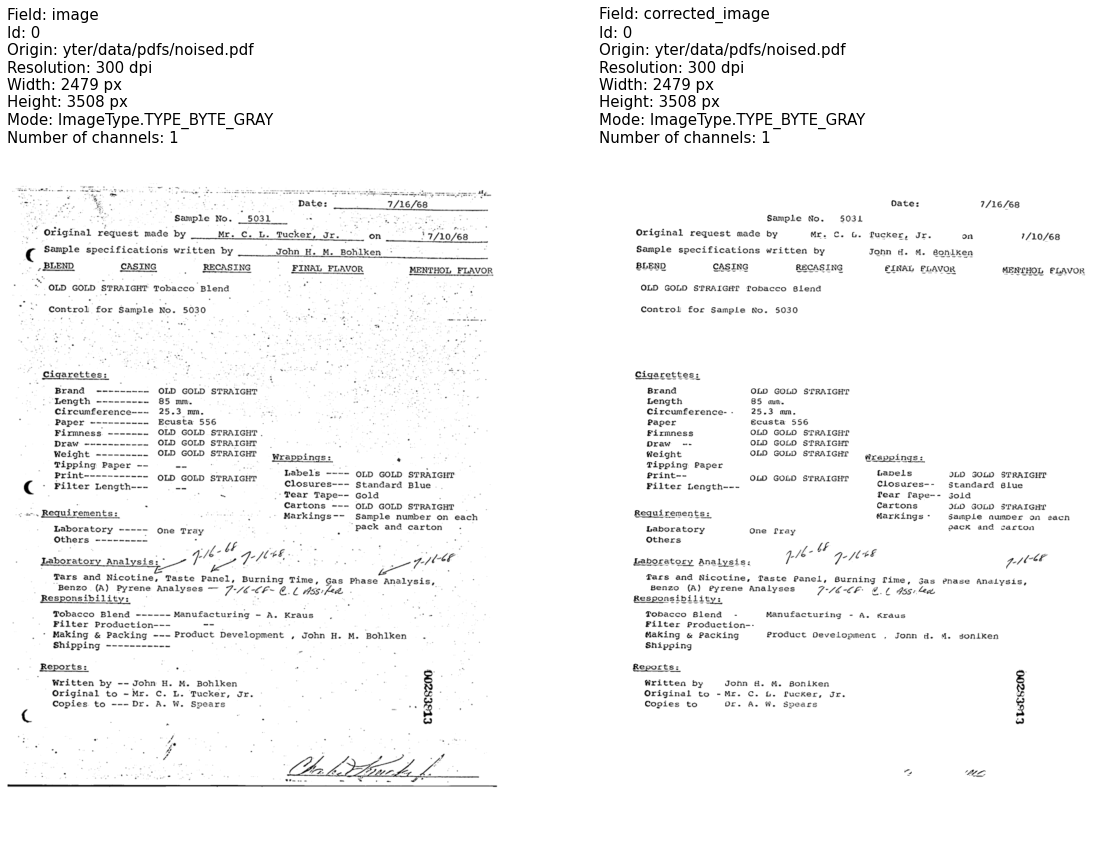

In [ ]:
display_images_horizontal(results, "image,corrected_image")